<a href="https://colab.research.google.com/github/pranay2310/Credit-Card-Default-Prediction/blob/main/Credit_Card_Default_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting whether a customer will default on his/her credit card </u></b>

## <b> Problem Description </b>

### This project is aimed at predicting the case of customers default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. We can use the [K-S chart](https://www.listendata.com/2019/07/KS-Statistics-Python.html) to evaluate which customers will default on their credit card payments


## <b> Data Description </b>

### <b>Attribute Information: </b>

### This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* ### X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* ### X2: Gender (1 = male; 2 = female).
* ### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* ### X4: Marital status (1 = married; 2 = single; 3 = others).
* ### X5: Age (year).
* ### X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* ### X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* ### X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#import xlrd

In [3]:
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 4.7 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [4]:
import xlrd

In [5]:
df = pd.read_excel("/content/drive/MyDrive/Almabetter/Capstone project/Credit Card Default Prediction/default_of_credit_card_clients.xls",sheet_name="Data",engine="xlrd", header=1)

In [6]:
df.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
27141,27142,240000,1,2,1,47,0,0,0,0,...,44351,193283,21682,34700,11005,8006,202000,8505,377000,0
11081,11082,50000,1,2,2,24,0,0,0,0,...,6284,6681,6813,1500,2000,1000,500,243,256,0
14670,14671,280000,2,3,2,47,-1,-1,-1,-1,...,27000,0,30460,39787,29000,27000,0,30460,5983,0
12044,12045,430000,2,1,1,37,-1,-1,-1,-1,...,5064,13258,2249,416,23547,5064,13258,2249,3686,0
27366,27367,390000,1,1,2,28,0,0,0,0,...,29661,21907,8205,6000,10000,2000,15000,5000,2000,0


In [7]:
#Column name 'default payment next month' is better to name it 'DEFAULT'. Shorter and without dot that could probably cause error in code.
#Column name 'PAY_0' would be better to name it 'PAY_1', to make it consistent with 'BILL_AMT1' and 'PAY_AMT1'.
df = df.rename(columns={'default payment next month': 'DEFAULT', 
                        'PAY_0': 'PAY_1'})
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
df.shape

(30000, 25)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

observation:
There is no null value present in data set.
All Datatype in integer format.

#Handling discrepancy in data

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


There are some contradicting data in the dataset. It could be error when building up the data, or incomplete definition and explanation. Althought there is additional information in discussion, still couldn't explain all.



1. One of the contradicting information is those who Paid in Full in recent    month, turn out to be default
2. Some client paid more than they should be, resulting a Negative Bill Amount. But still end up being default.
3. Some client Bill Amount is much higher than their Credit Limit provided, which seldom happen in real case.





In [11]:
error1 = df.query('BILL_AMT1 < 0 and DEFAULT == 1').loc[:,('ID','BILL_AMT1','DEFAULT')]
error1.sample(5)

,ID,BILL_AMT1,DEFAULT
23648,23649,-109,1
25466,25467,-307,1
10740,10741,-3,1
26587,26588,-47,1
27457,27458,-20,1


In [12]:
error2 = df.query('BILL_AMT1 > LIMIT_BAL').loc[:,('ID','LIMIT_BAL','BILL_AMT1')]
error2.sample(5)

,ID,LIMIT_BAL,BILL_AMT1
13118,13119,140000,141530
25774,25775,70000,79346
15300,15301,150000,213638
23795,23796,120000,123270
23739,23740,80000,80106


# Univariant Analysis

In [13]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [14]:
#Check unique value of each categorical variable
print('SEX' + str(sorted(df['SEX'].unique())))
print('EDUCATION' + str(sorted(df['EDUCATION'].unique())))
print('MARRIAGE' + str(sorted(df['MARRIAGE'].unique())))
print('PAY_1' + str(sorted(df['PAY_1'].unique())))
print('DEFAULT' + str(sorted(df['DEFAULT'].unique())))

SEX[1, 2]
EDUCATION[0, 1, 2, 3, 4, 5, 6]
MARRIAGE[0, 1, 2, 3]
PAY_1[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
DEFAULT[0, 1]


##Column 2 : 'LIMIT_BAL'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


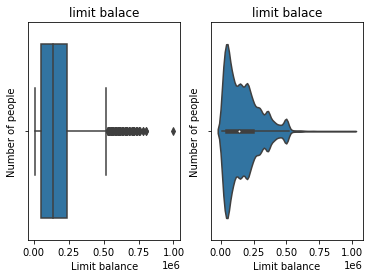

In [15]:
plt.subplot(1, 2, 1) # index 1
sns.boxplot(x= "LIMIT_BAL", data=df)
plt.xlabel("Limit balance")
plt.ylabel("Number of people")
plt.title("limit balace")


plt.subplot(1, 2, 2) # index 2
sns.violinplot(df["LIMIT_BAL"], orient="h")
plt.xlabel("Limit balance")
plt.ylabel("Number of people")
plt.title("limit balace")

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show>

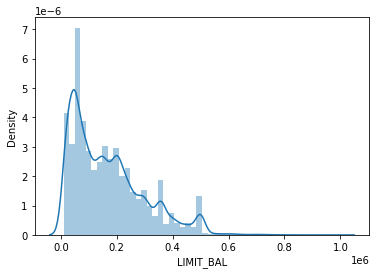

In [16]:
sns.distplot(df.LIMIT_BAL)
plt.ticklabel_format(useOffset=False)
plt.show

##Column 3: SEX

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


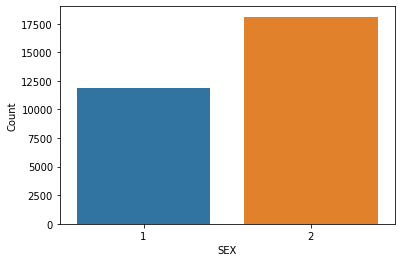

In [17]:
sns.countplot(df.SEX)
plt.xlabel('SEX')
plt.ylabel('Count')
plt.show()

## column 4: EDUCATION

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


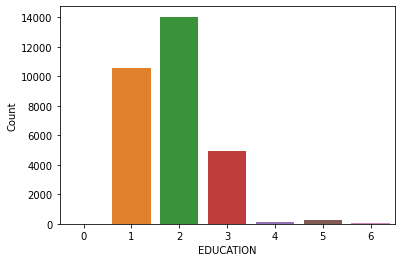

In [18]:
sns.countplot(df.EDUCATION)
plt.xlabel('EDUCATION')
plt.ylabel('Count')
plt.show()

## Column 5: Marriage

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


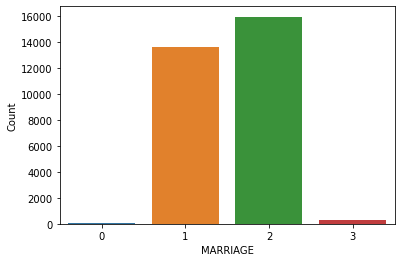

In [19]:
sns.countplot(df.MARRIAGE)
plt.xlabel('MARRIAGE')
plt.ylabel('Count')
plt.show()

## Column 6: AGE

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


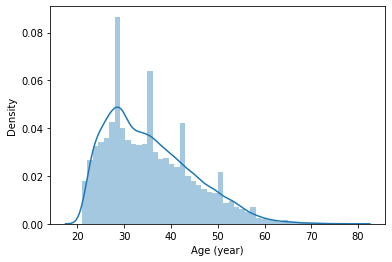

In [20]:
sns.distplot(df.AGE)
plt.xlabel("Age (year)")
#plt.ylabel("Number of people")
plt.show()

## COLUMN 7 to 12:

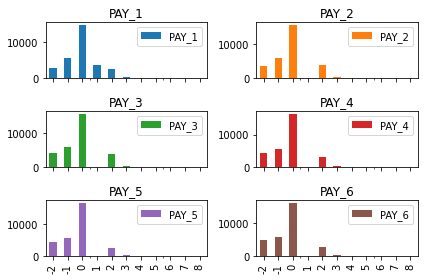

In [21]:
df.iloc[:,6:12].apply(pd.value_counts).plot(kind="bar", subplots=True, layout=(3,2), legend=True)

plt.tight_layout()  
plt.show()

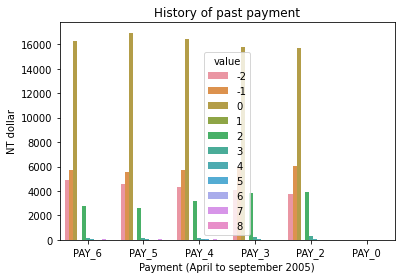

In [22]:
sns.countplot(x="variable", hue="value", data=pd.melt(df.iloc[:,6:12]), order = ["PAY_6","PAY_5","PAY_4","PAY_3","PAY_2","PAY_0"] )
plt.title("History of past payment")
plt.xlabel("Payment (April to september 2005)")
plt.ylabel("NT dollar")
plt.show()

## column 13 to 18 :

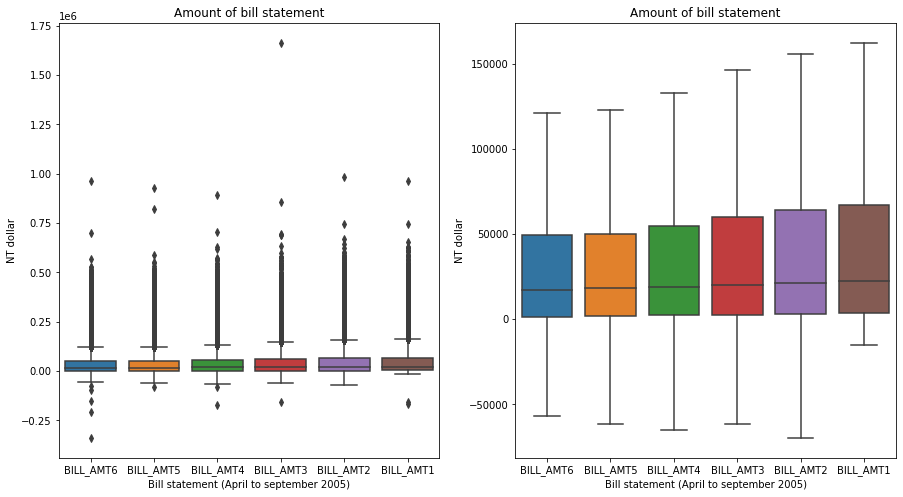

In [23]:
plt.rcParams["figure.figsize"] = [15,8]
plt.subplot(1, 2, 1) # index 1
sns.boxplot( data=df.iloc[:,12:18], 
            order=["BILL_AMT6","BILL_AMT5","BILL_AMT4","BILL_AMT3","BILL_AMT2","BILL_AMT1"])
plt.title("Amount of bill statement")
plt.xlabel("Bill statement (April to september 2005)")
plt.ylabel("NT dollar")


plt.subplot(1, 2, 2) # index 2
sns.boxplot( data=df.iloc[:,12:18],
            showfliers=False,
            order=["BILL_AMT6","BILL_AMT5","BILL_AMT4","BILL_AMT3","BILL_AMT2","BILL_AMT1"])
plt.title("Amount of bill statement")
plt.xlabel("Bill statement (April to september 2005)")
plt.ylabel("NT dollar")

plt.show()            


## column 19 to 24

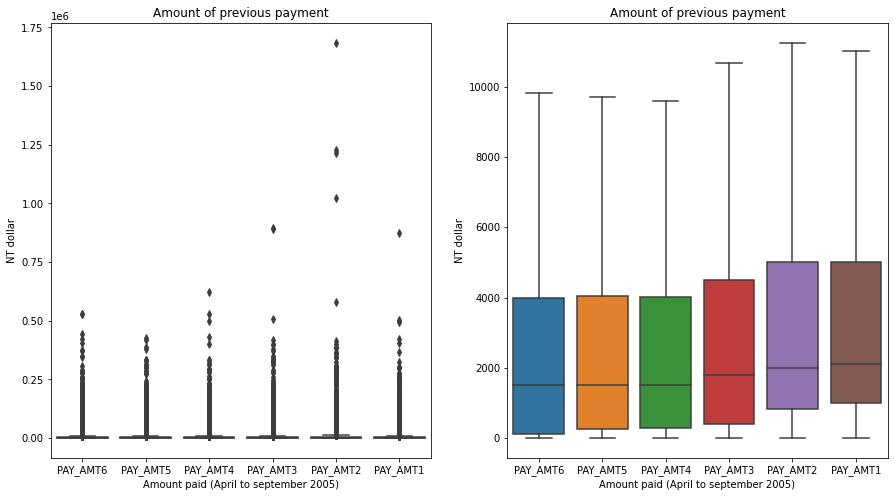

In [24]:
plt.rcParams["figure.figsize"] = [15,8]
plt.subplot(1, 2, 1) # index 1
sns.boxplot( data=df.iloc[:,18:24], 
            order=["PAY_AMT6","PAY_AMT5","PAY_AMT4","PAY_AMT3","PAY_AMT2","PAY_AMT1"])
plt.title("Amount of previous payment")
plt.xlabel("Amount paid (April to september 2005)")
plt.ylabel("NT dollar")


plt.subplot(1, 2, 2) # index 2
sns.boxplot( data=df.iloc[:,18:24],
            showfliers=False,
            order=["PAY_AMT6","PAY_AMT5","PAY_AMT4","PAY_AMT3","PAY_AMT2","PAY_AMT1"])
plt.title("Amount of previous payment")
plt.xlabel("Amount paid (April to september 2005)")
plt.ylabel("NT dollar")

plt.show()

## column 25: DEFAULT

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


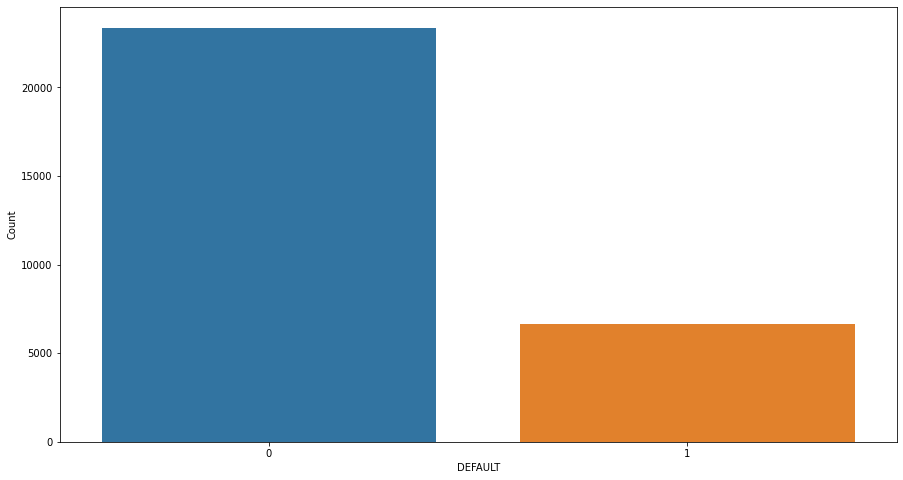

In [25]:
sns.countplot(df.DEFAULT)
plt.xlabel('DEFAULT')
plt.ylabel('Count')
plt.show()

# Bivariant analysis

In [26]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


##LIMIT_BAL vs Default

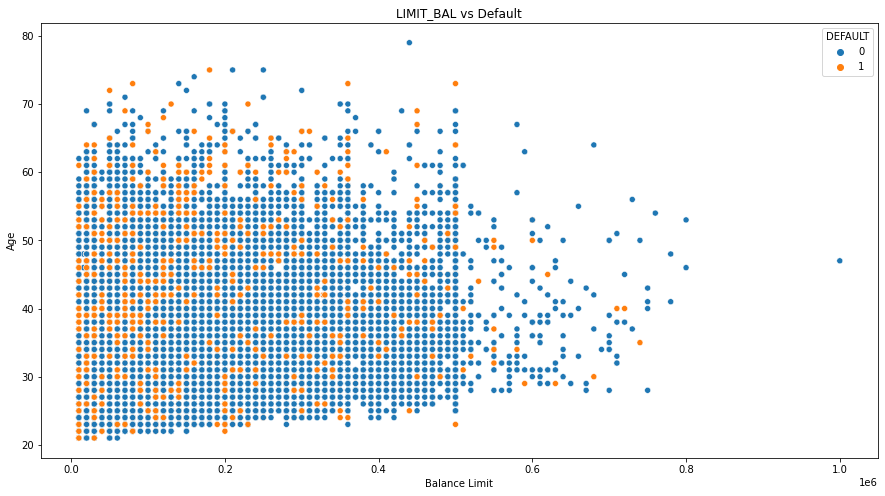

In [27]:
sns.scatterplot(x = "LIMIT_BAL", y = "AGE",data=df, hue='DEFAULT')
plt.xlabel('Balance Limit')
plt.ylabel('Age')
plt.title("LIMIT_BAL vs Default")
plt.show()

## SEX vs Default#

In [28]:
#Gender (1 = male; 2 = female)
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

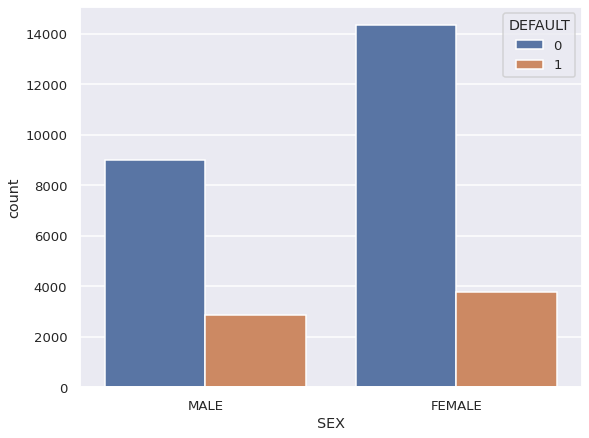

In [29]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)

gen = sns.countplot(x='SEX', hue='DEFAULT', data=df)
gen.set_xticklabels(['MALE','FEMALE'])
plt.show()

In [30]:
default0 = df.groupby(df['SEX'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['SEX'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('SEX').size().reset_index(name='TOTAL')

genTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
genTable['SEX'] = ['Male','Female']

genTable

,SEX,NOT_DEFAULT,DEFAULT,TOTAL
0,Male,9015,2873,11888
1,Female,14349,3763,18112


##Education vs DEFAULT

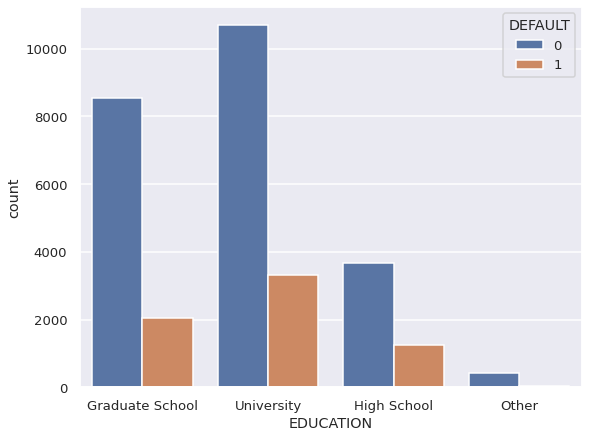

In [43]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)
# fdmkl
edu = sns.countplot(x='EDUCATION', hue='DEFAULT', data=df)
edu.set_xticklabels(['Graduate School','University','High School','Other'])
plt.show()

In [46]:
default0 = df.groupby(df['EDUCATION'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['EDUCATION'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('EDUCATION').size().reset_index(name='TOTAL')
#sxcxa
eduTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
eduTable['EDUCATION'] = ['Graduate School','University','High School','Other']

eduTable

,EDUCATION,NOT_DEFAULT,DEFAULT,TOTAL
0,Graduate School,8549,2036,10585
1,University,10700,3330,14030
2,High School,3680,1237,4917
3,Other,435,33,468


In [52]:
eduTable['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
eduTable['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)
# DFSDF
eduPct = eduTable.iloc[:,0:3]
eduPct = eduPct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

eduPct

,EDUCATION,NOT_DEFAULT(%),DEFAULT(%)
0,Graduate School,80.77,19.23
1,University,76.27,23.73
2,High School,74.84,25.16
3,Other,92.95,7.05


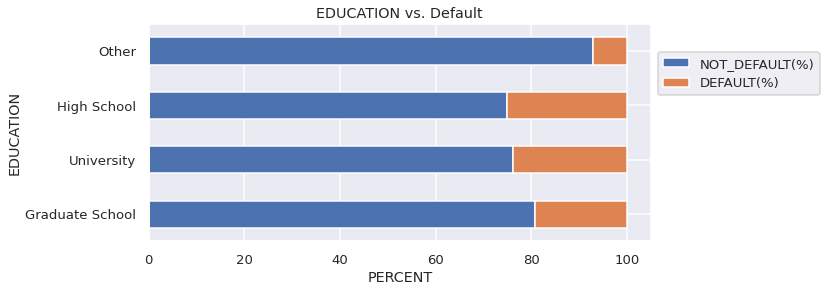

In [56]:
sns.set(rc={'figure.figsize':(9,4)})
sns.set_context("talk", font_scale=0.8)
#ASD
ax = eduPct.plot(x='EDUCATION', kind='barh', stacked=True, title='EDUCATION vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))
plt.show()

Although the Default Count for High School is lower than Graduate School & University. But in terms of Default Percentage, those with High School level have higher chance of Default.

# Marriage vs. Default

In [37]:
#Value in EDUCATION not define completely. Since 0, 4, 5, 6 all being define as other (or unknown), will be better to group them together and name it 4.
fill = (df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6)
df.loc[fill, 'EDUCATION'] = 4

print('EDUCATION ' + str(sorted(df['EDUCATION'].unique())))

EDUCATION [1, 2, 3, 4]


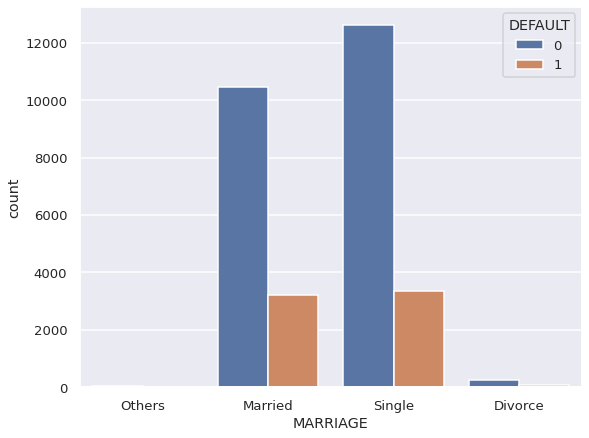

In [38]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)

marri = sns.countplot(x="MARRIAGE", hue='DEFAULT', data=df )
marri.set_xticklabels(['Others','Married','Single','Divorce'])
plt.show()

In [39]:
default0 = df.groupby(df['MARRIAGE'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['MARRIAGE'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('MARRIAGE').size().reset_index(name='TOTAL')

marriTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
marriTable['MARRIAGE'] = ['Others','Married','Single','Divorce']

marriTable

,MARRIAGE,NOT_DEFAULT,DEFAULT,TOTAL
0,Others,49,5,54
1,Married,10453,3206,13659
2,Single,12623,3341,15964
3,Divorce,239,84,323


In [40]:
marriTable['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
marriTable['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)

marriPct = marriTable.iloc[:,0:3]
marriPct = marriPct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

marriPct

,MARRIAGE,NOT_DEFAULT(%),DEFAULT(%)
0,Others,90.74,9.26
1,Married,76.53,23.47
2,Single,79.07,20.93
3,Divorce,73.99,26.01


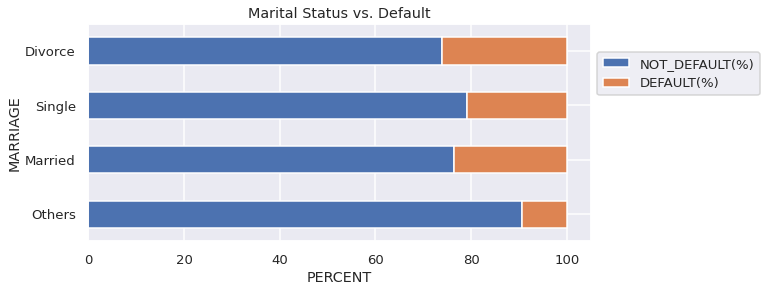

In [41]:
sns.set(rc={'figure.figsize':(9,4)})
sns.set_context("talk", font_scale=0.8)

ax = marriPct.plot(x='MARRIAGE', kind='barh', stacked=True, title='Marital Status vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))
plt.show()

Although the Default Count for Divorce is way lower than Single & Married. But in terms of Default Percentage, those who Divorce have higher chance of Default.

# Age vs. Default

In [57]:
df['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


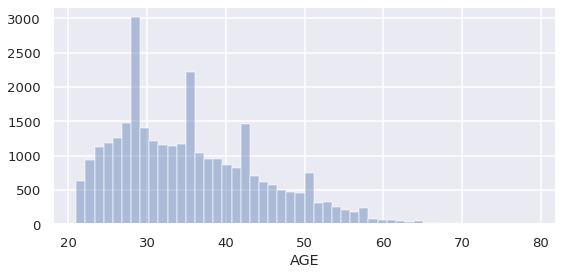

In [58]:
sns.distplot(df['AGE'], norm_hist=False, kde=False);

# CORRELATION

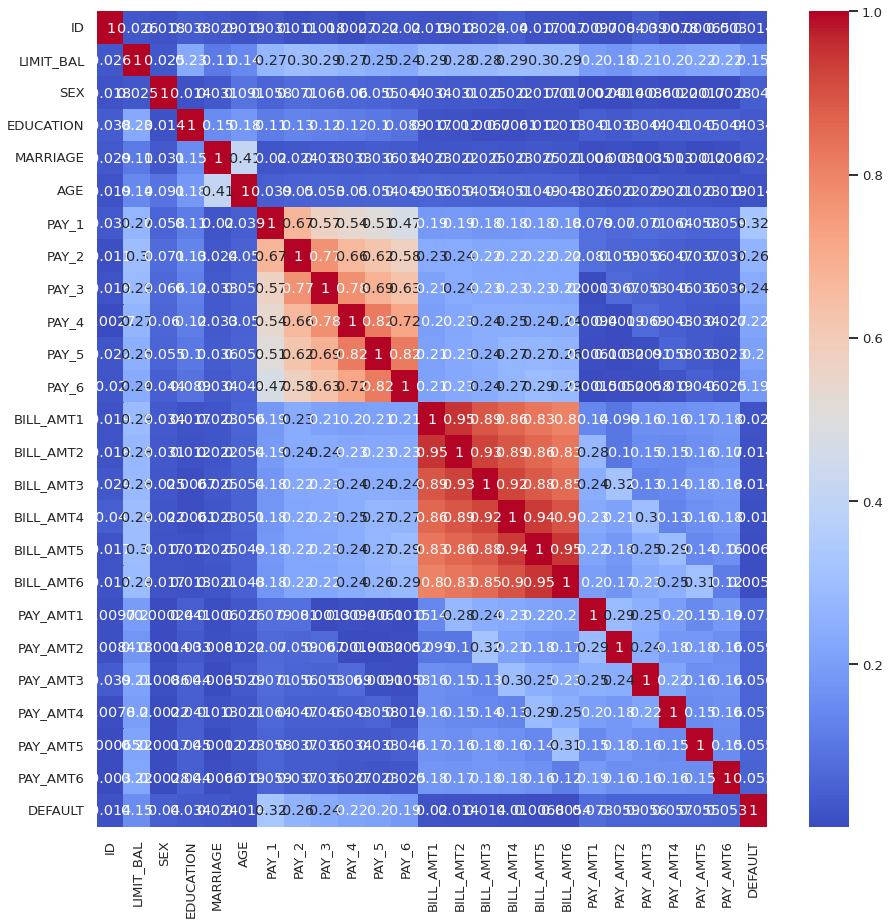

In [59]:
## Correlation
plt.figure(figsize=(15,15))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')
plt.show()